<a href="https://colab.research.google.com/github/DanielhCarranza/Machine-Learning-in-Health/blob/master/Pneumothorax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pneumothorax
Imagine suddenly gasping for air, helplessly breathless for no apparent reason. Could it be a collapsed lung? In the future, your entry in this competition could predict the answer.

Pneumothorax can be caused by a blunt chest injury, damage from underlying lung disease, or most horrifying—it may occur for no obvious reason at all. On some occasions, a collapsed lung can be a life-threatening event.

Pneumothorax is usually diagnosed by a radiologist on a chest x-ray, and can sometimes be very difficult to confirm. An accurate AI algorithm to detect pneumothorax would be useful in a lot of clinical scenarios. AI could be used to triage chest radiographs for priority interpretation, or to provide a more confident diagnosis for non-radiologists.

The Society for Imaging Informatics in Medicine (SIIM) is the leading healthcare organization for those interested in the current and future use of informatics in medical imaging. Their mission is to advance medical imaging informatics across the enterprise through education, research, and innovation in a multi-disciplinary community. Today, they need your help.

In this competition, you’ll develop a model to classify (and if present, segment) pneumothorax from a set of chest radiographic images. If successful, you could aid in the early recognition of pneumothoraces and save lives.

### What should I expect the data format to be?
The data is comprised of images in DICOM format and annotations in the form of image IDs and run-length-encoded (RLE) masks. Some of the images contain instances of pneumothorax (collapsed lung), which are indicated by encoded binary masks in the annotations. Some images have multiple annotations.

`1.2.276.0.7230010.3.1.4.8323329.14508.1517875252.443873,387620 23 996 33 986 43 977 51 968 58 962 65 956 70 952 74 949 76 946 79
`
Images without pneumothorax have a mask value of -1.

`1.2.276.0.7230010.3.1.4.8323329.1034.1517875166.8504,-1`

### Setup

In [ ]:
from google.colab import auth
auth.authenticate_user()

project_id = 'project'
bucket_name='datasets'


!gcloud config set project {project_idJL}

def ls_gcp(path):
  ! gsutil ls gs://{path}

def upload_files_to_gcp(local_path, bucket_path):
  ! gsutil -m cp -r {local_path} gs://{bucket_path}

def download_files_from_gcp(bucket_path, local_path):
  if not os.path.isdir(local_path): os.mkdir(local_path)
  ! gsutil -m cp -r gs://{bucket_path} {local_path} 
    
ls_gcp(path_datasets), ls_gcp(path_models)

In [ ]:
"""Script to download all instances in a DICOM Store."""
import os
import posixpath
from concurrent import futures
from retrying import retry
import google.auth
from google.auth.transport.requests import AuthorizedSession

# URL of CHC API
CHC_API_URL = 'https://healthcare.googleapis.com/v1beta1'
PROJECT_ID = 'kaggle-siim-healthcare'
REGION = 'us-central1'
DATASET_ID = 'siim-pneumothorax'
TRAIN_DICOM_STORE_ID = 'dicom-images-train'
TEST_DICOM_STORE_ID = 'dicom-images-test'


@retry(wait_exponential_multiplier=1000, wait_exponential_max=10000)
def download_instance(dicom_web_url, dicom_store_id, study_uid, series_uid,
                      instance_uid, credentials):
    """Downloads a DICOM instance and saves it under the current folder."""
    instance_url = posixpath.join(dicom_web_url, 'studies', study_uid, 'series',
                                  series_uid, 'instances', instance_uid)
    authed_session = AuthorizedSession(credentials)
    response = authed_session.get(
        instance_url, headers={'Accept': 'application/dicom; transfer-syntax=*'})
    file_path = posixpath.join(dicom_store_id, study_uid, series_uid,
                               instance_uid)
    filename = '%s.dcm' % file_path
    if not os.path.exists(filename):
        os.makedirs(os.path.dirname(filename))
    with open(filename, 'wb') as f:
        f.write(response.content)


def download_all_instances(dicom_store_id, credentials):
    """Downloads all DICOM instances in the specified DICOM store."""
    # Get a list of all instances.
    dicom_web_url = posixpath.join(CHC_API_URL, 'projects', PROJECT_ID,
                                   'locations', REGION, 'datasets', DATASET_ID,
                                   'dicomStores', dicom_store_id, 'dicomWeb')
    qido_url = posixpath.join(dicom_web_url, 'instances')
    authed_session = AuthorizedSession(credentials)
    response = authed_session.get(qido_url, params={'limit': '15000'})
    if response.status_code != 200:
        print(response.text)
        return
    content = response.json()
    # DICOM Tag numbers
    study_instance_uid_tag = '0020000D'
    series_instance_uid_tag = '0020000E'
    sop_instance_uid_tag = '00080018'
    value_key = 'Value'
    with futures.ThreadPoolExecutor() as executor:
        future_to_study_uid = {}
        for instance in content:
            study_uid = instance[study_instance_uid_tag][value_key][0]
            series_uid = instance[series_instance_uid_tag][value_key][0]
            instance_uid = instance[sop_instance_uid_tag][value_key][0]
            future = executor.submit(download_instance, dicom_web_url, dicom_store_id,
                                     study_uid, series_uid, instance_uid, credentials)
            future_to_study_uid[future] = study_uid
        processed_count = 0
        for future in futures.as_completed(future_to_study_uid):
            try:
                future.result()
                processed_count += 1
                if not processed_count % 100 or processed_count == len(content):
                    print('Processed instance %d out of %d' %
                          (processed_count, len(content)))
            except Exception as e:
                print('Failed to download a study. UID: %s \n exception: %s' %
                      (future_to_study_uid[future], e))


def main(argv=None):
    credentials, _ = google.auth.default()
    print('Downloading all instances in %s DICOM store' % TRAIN_DICOM_STORE_ID)
    download_all_instances(TRAIN_DICOM_STORE_ID, credentials)
    print('Downloading all instances in %s DICOM store' % TEST_DICOM_STORE_ID)
    download_all_instances(TEST_DICOM_STORE_ID, credentials)

In [ ]:
main()

In [ ]:
PROJECT_ID="kaggle-siim-healthcare"
REGION="us-central1"
DATASET_ID="siim-pneumothorax"
FHIR_STORE_ID="fhir-masks-train"
DOCUMENT_REFERENCE_ID="d70d8f3e-990a-4bc0-b11f-c87349f5d4eb"
ann=f"https://healthcare.googleapis.com/v1beta1/projects/{PROJECT_ID}/locations/{REGION}/datasets/{DATASET_ID}/fhirStores/{FHIR_STORE_ID}/fhir/DocumentReference/{DOCUMENT_REFERENCE_ID}"

In [ ]:
! curl -X GET -H "Authorization: Bearer "$(gcloud auth print-access-token) https://cdn.ymaws.com/siim.org/resource/resmgr/community/train-rle.csv -o train-rle.csv

## EDA

In [ ]:
import fastai
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.callbacks.hooks import *
from fastai.vision.interpret import SegmentationInterpretation


import os
import gc
import cv2 
import numpy as np 
import pandas as pd 
import seaborn as sns
import pydicom as dcm
import matplotlib.pyplot as plt

from skimage import exposure
from sklearn.model_selection import KFold
from sklearn.metrics import auc, roc_curve, precision_recall_curve
from sklearn.metrics import classification_report

In [ ]:
path= Path('dicom-images-train')
path_test=Path('dicom-images-test')
path.ls()[:5]

[PosixPath('dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.31721.1517875156.468687'),
 PosixPath('dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.3158.1517875176.372795'),
 PosixPath('dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.2275.1517875171.896098'),
 PosixPath('dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.3373.1517875177.537105'),
 PosixPath('dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.1669.1517875168.837320')]

In [ ]:
train_rle= pd.read_csv('train-rle.csv')
train_rle.head()

,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.5597.151787518...,-1
1,1.2.276.0.7230010.3.1.4.8323329.12515.15178752...,-1
2,1.2.276.0.7230010.3.1.4.8323329.4904.151787518...,175349 7 1013 12 1009 17 1005 19 1003 20 1002...
3,1.2.276.0.7230010.3.1.4.8323329.32579.15178751...,407576 2 1021 7 1015 10 1013 12 1011 14 1008 ...
4,1.2.276.0.7230010.3.1.4.8323329.32579.15178751...,252069 1 1021 3 1020 4 1018 5 1018 6 1016 7 1...


In [ ]:
files= get_files(path, recurse=True, extensions='.dcm')
test_files= get_files(path_test, recurse=True, extensions='.dcm')
files[0:5]

[PosixPath('dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.31721.1517875156.468687/1.2.276.0.7230010.3.1.3.8323329.31721.1517875156.468686/1.2.276.0.7230010.3.1.4.8323329.31721.1517875156.468688.dcm'),
 PosixPath('dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.3158.1517875176.372795/1.2.276.0.7230010.3.1.3.8323329.3158.1517875176.372794/1.2.276.0.7230010.3.1.4.8323329.3158.1517875176.372796.dcm'),
 PosixPath('dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.2275.1517875171.896098/1.2.276.0.7230010.3.1.3.8323329.2275.1517875171.896097/1.2.276.0.7230010.3.1.4.8323329.2275.1517875171.896099.dcm'),
 PosixPath('dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.3373.1517875177.537105/1.2.276.0.7230010.3.1.3.8323329.3373.1517875177.537104/1.2.276.0.7230010.3.1.4.8323329.3373.1517875177.537106.dcm'),
 PosixPath('dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.1669.1517875168.837320/1.2.276.0.7230010.3.1.3.8323329.1669.1517875168.837319/1.2.276.0.7230010.3.1.4.8323329.1669.1517875

In [ ]:
def read_dcm(file): 
  return dcm.read_file(str(file))

def plot_dcm(img,size=(10,10)):
  img = img if not isinstance(img, dcm.dataset.FileDataset) else img.pixel_array
  img=exposure.equalize_adapthist(img)/255 #correct contrast
  plt.figure(figsize=size)
  plt.imshow(img,cmap='gray')
  plt.show()
  
def get_img_pair(files,i):
  return read_dcm(files[i]), rle2mask(get_labels(files[i]), (1024,1024))

def plot_overlay(img,mask, size=(10,10), cmap='jet', alpha=0.6):
  img = img if not isinstance(img, dcm.dataset.FileDataset) else img.pixel_array
  mask= rle2mask(mask, 1024, 1024)  if isinstance(mask,str) else mask
  plt.figure(figsize=size)
  plt.imshow(img,cmap='gray')
  plt.imshow(mask, cmap=cmap, alpha=alpha)
  plt.show()
  

In [ ]:
get_lb = lambda df,item: df[df.ImageId==item.name[:-4]].values[0][-1]
get_labels=partial(get_lb, train_rle)
get_labels(files[0])

' -1'

In [ ]:
seg_files=[f for f in files if get_labels(f) !=' -1']
print(f'Seg files len {len(seg_files)}')

Seg files len 2379


In [ ]:
SEED=2019
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    #tf.set_random_seed(seed)
seed_everything(SEED)

In [ ]:
def rle2mask(rle:str, shape:tuple=(1024,1024)):
    if rle==' -1': return np.zeros(shape, np.uint8).T
    else:
      mask= np.zeros(shape[0]*shape[1], np.uint)
      array = np.asarray([int(x) for x in rle.split()])
      starts = array[0::2]
      lengths = array[1::2]

      current_position = 0
      for index, start in enumerate(starts):
          current_position += start
          mask[current_position:current_position+lengths[index]] = 1
          current_position += lengths[index]
      return mask.reshape(shape).T
  
def open_mask_rle(mask_rle:str, shape:Tuple[int, int])->ImageSegment:
    "Return `ImageSegment` object create from run-length encoded string in `mask_lre` with size in `shape`."
    x = FloatTensor(rle2mask(str(mask_rle), shape).astype(np.uint8))
    x = x.view(shape[1], shape[0], -1)
    return ImageSegment(x.permute(2,0,1))


def open_dcm_image(fn:PathOrStr, div:bool=True, convert_mode:str='RGB', cls:type=Image,
        after_open:Callable=None)->Image:
    "Return `Image` object created from image in file `fn`."
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", UserWarning) # EXIF warning from TiffPlugin
        x = exposure.equalize_adapthist(dcm.read_file(str(fn)).pixel_array)
        x = ((x*255)).clip(0,255).astype(np.uint8)
        x=np.stack((x,)*3, axis=-1) 
        x = PIL.Image.fromarray(x).convert(convert_mode)
    if after_open: x = after_open(x)
    x = pil2tensor(x,np.float32)
    if div: x.div_(255)
    return cls(x)
  
# Setting transformations on masks to False on test set
def transform(self, tfms:Optional[Tuple[TfmList,TfmList]]=(None,None), **kwargs):
    if not tfms: tfms=(None,None)
    assert is_listy(tfms) and len(tfms) == 2
    self.train.transform(tfms[0], **kwargs)
    self.valid.transform(tfms[1], **kwargs)
    kwargs['tfm_y'] = False # Test data has no labels
    if self.test: self.test.transform(tfms[1], **kwargs)
    return self
fastai.data_block.ItemLists.transform = transform

In [ ]:
class PSegmentationLabelList(SegmentationLabelList):
  def open(self,fn): return open_mask_rle(fn, shape=(1024,1024))

class PImageList(ImageList):
  def open(self,fn): return open_dcm_image(fn)
  
class PSegmentationItemList(PImageList):
  _label_cls = PSegmentationLabelList

In [ ]:
bs = 16
n_acc = 64//bs #gradinet accumulation steps
nfolds = 4
sz=256
#eliminate all predictions with a few (noise_th) pixesls
noise_th = 75.0*(sz/128.0)**2 #threshold for the number of predicted pixels
best_thr0 = 0.2 #preliminary value of the threshold for metric calculation

In [ ]:
def get_fdata(fold, nfolds=4, size=(256,256), bs=16, **kwargs):
  kf = KFold(n_splits=nfolds, shuffle=True, random_state=SEED)
  valid_idx = list(kf.split(list(range(len(files)))))[fold][1]
  return (PSegmentationItemList(files)
       .split_by_idx(valid_idx)
       .label_from_func(get_labels, classes=['void','Pneumothorax'])
       .add_test(test_files, label=None)
       .transform(tfms=get_transforms(), size=size, tfm_y=True)
       .databunch(bs=bs, num_workers=0, **kwargs)
       .normalize())
      

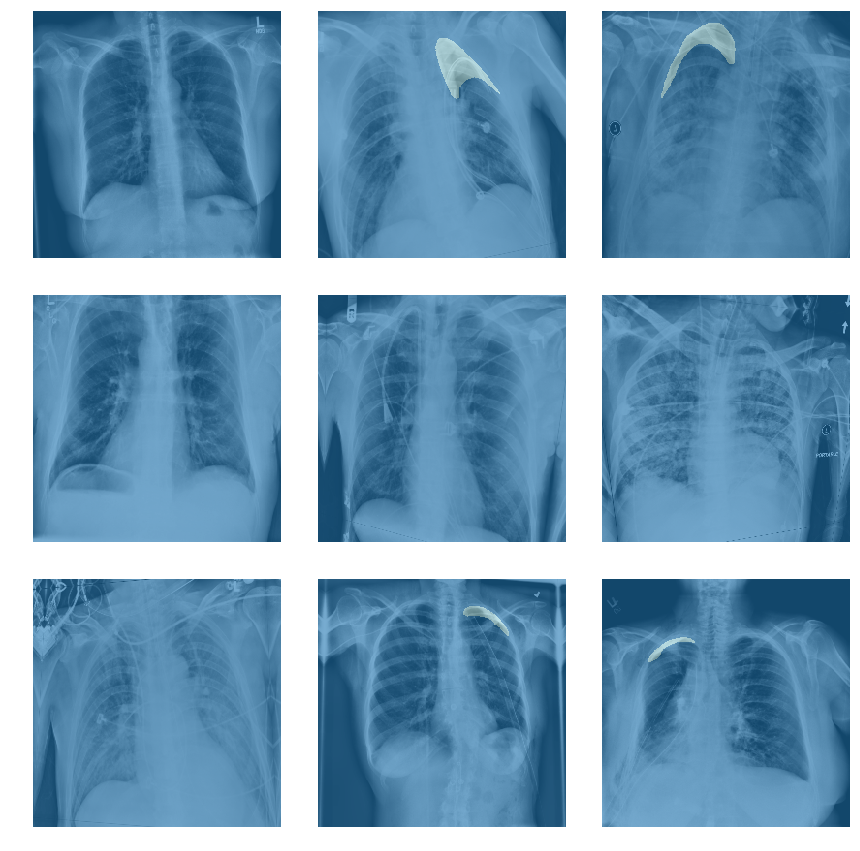

In [ ]:
data= get_fdata(0)
data.show_batch(rows=3, alpha=0.6)

In [ ]:
(data.train_ds.x[0]).shape

torch.Size([3, 1024, 1024])

In [ ]:
# src = (PSegmentationItemList(files)
#        .split_by_rand_pct()
#        .label_from_func(get_labels, classes=['void','Pneumothorax']))

# def get_data(bs=8, size=(224,224),**kwargs):
#     return (src.transform(tfms=get_transforms(), size=size, tfm_y=True)
#             .databunch(bs=bs, num_workers=0, **kwargs)
#             .normalize())
  
# data= get_data(bs=16, size=256)
# data.show_batch(rows=3, alpha=0.6)

## ResNet  encoder U-NET with Hypercolumns 

**Problem setting**: We assume an object detection system that gives us a set of detections. Each detection comes with a bounding box, a category label and a score (and sometimes an initial segmentation hypothesis). The detections have already been subjected to non-maximum suppression. For every detection, we want to segment out the object, segment its parts or predict its keypoints.
For ***segmentation***, the *heatmap* encodes the *probability* that a particular location is inside the object.
In each case, we predict a 50×50 heatmap that we resize to the size (size 50 above is arbitrary) of the expanded bounding box and splat onto theimage. 

**Computing the hypercolumn representation:**
All the intermediate outputs in a CNN are feature maps (the output of a fully connected layer can be seen as a 1×1 feature map). However, because of subsampling and pooling operations in the CNN, these feature maps need not be at the same resolution as the input or the target output size. So which unit lies above a particular location is ambiguous.
We get around this by simply resizing each feature map to the size we want with bilinear interpolation.
We concatenate features from some or all of the feature maps in the network into one long vector for every location which we call the hypercolumn at that location.

**Interpolating into a grid of classifiers**: Because these feature maps are the result of convolutions and poolings, they do not encode any information about where in the bounding box a given pixel lies. However, location can be an important feature.


**Efficient classification using convolutions and upsampling:**

Observe that applying a classifier to each location in afeature map is the same as a 1 × 1 convolution. Thus, to run a linear classifier on top of hypercolumn features, we break it into blocks corresponding to each feature map, run 1 × 1 convolutions on each feature map to produce score maps, upsample all score maps to the target resolution, and sum. 

We consider a further modification to this pipeline where we replace the 1 × 1 convolution with a general n × n convolution. This corresponds to looking not only at the unit directly above a pixel but also the neighborhood of the unit. This captures the pattern of activations of a whole neighborhood, which can be more informative than a single unit, especially in the lower layers of the network.

**Training classifiers for segmentation and part localization:**

For each category we take bottom-up MCG candidatesthat overlap a ground truth instance by 70% or more. Foreach such candidate, we find the ground truth instance it overlaps most with, and crop that ground truth instance to the expanded bounding box of the candidate.

In other words, instead of obtaining separate convolutional feature maps for each box by passing the box separately through a CNN, we can pass the entire image once through the convolutional layers of
the CNN and simply crop the appropriate box from each image-level feature map to get the corresponding feature map for the box. Then each such cropped feature map can be convolved with the appropriate classifier weights w(j) and the responses upsampled and summed as before.


 The idea of Hypercolumns is schematically illustrated in the following figure. ![](https://i.ibb.co/3y7f8rj/Hypercolumns1.png)
 
 
Each upscaling block is connected to the output layer through linear resize to the original image size. So the final image is produced based on concatenation of U-net output with resized outputs of intermediate layers. These skip-connections provide a shortcut for gradient flow improving model performance and convergence speed. Since intermediate layers have many channels, their upscaling and use as an input for the final layer would introduce a significant overhead in terms the computational time and memory. Therefore, 3x3 convolutions are applied (factorization) before the resize to reduce the number of channels.

In [ ]:
from fastai.vision.learner import create_head, cnn_config, num_features_model, create_head
from fastai.callbacks.hooks import model_sizes, hook_outputs, dummy_eval, Hook, _hook_inner
from fastai.vision.models.unet import _get_sfs_idxs, UnetBlock

In [ ]:
class Hcolumns(nn.Module):
  def __init__(self, hook:Collection[Hook], nc:Collection[int]=None):
    super().__init__()
    self.hooks=hook
    self.n=len(self.hooks)
    self.factorization=None # UpSampling Hcolumns
    if nc is not None:
      self.factorization=nn.ModuleList()
      for i in range(self.n):
        self.factorization.append(nn.Sequential(
            conv2d(nc[i],nc[-1],  3, padding=1, bias=True), 
            conv2d(nc[-1],nc[-1], 3, padding=1, bias=True)))
        
  def forward(self, x:Tensor):
    n= len(self.hooks)
    out=[F.interpolate(self.hooks[i].stored if self.factorization is None  
                       else self.factorization[i](self.hooks[i].stored), 
                       scale_factor=2**(self.n-i), mode='bilinear', align_corners=True) for i in range(self.n)] + [x]
    return torch.cat(out,dim=1)

In [ ]:
class DynamicUnet_Hcolumns(SequentialEx):
  def __init__(self, encoder:nn.Module, n_classes:int, img_size:Tuple[int,int]=(256,256), 
               blur:bool=False, blur_final=True, self_attention:bool=False,
               y_range:Optional[Tuple[float,float]]=False,
               last_cross:bool=True, bottle:bool=False, **kwargs):
      # Encoder
      sfs_szs= model_sizes(encoder, size=img_size) # feature sizes
      sfs_idx= list(reversed(_get_sfs_idxs(sfs_szs)))
      self.sfs= hook_outputs([encoder[i] for i in sfs_idx])
      x= dummy_eval(encoder, img_size).detach()

      ni= sfs_szs[-1][1] # 512
      middle_conv= nn.Sequential(conv_layer(ni, ni*2, **kwargs),
                                 conv_layer(ni*2, ni, **kwargs)).eval()
      x=middle_conv(x)
      layers=[encoder, batchnorm_2d(ni), nn.ReLU(), middle_conv] 

      # Hypercolumns hooks
      self.hc_hooks= [Hook(layers[-1], _hook_inner, detach=False)]
      hc_c =[x.shape[1]]

      # Decoder 
      for i, idx in enumerate(sfs_idx):
          not_final = i!=len(sfs_idx)-1
          up_in_c, x_in_x = int(x.shape[1]), int(sfs_szs[idx][1])
          do_blur= blur and (not_final or blur_final)
          sa= self_attention and (i==len(sfs_idx)-3)
          unet_block= UnetBlock(up_in_c, x_in_x, self.sfs[i], final_div=not_final,
                                blur=do_blur,self_attention=sa,**kwargs).eval()
          layers.append(unet_block)
          x= unet_block(x)
          # Hypercolumns
          self.hc_hooks.append(Hook(layers[-1],_hook_inner,detach=False))
          hc_c.append(x.shape[1])

      ni = x.shape[1]
      if img_size != sfs_szs[0][-2:]: layers.append(PixelShuffle_ICNR(ni, **kwargs))
      if last_cross:
          layers.append(MergeLayer(dense=True))
          ni += in_channels(encoder)
          layers.append(res_block(ni, bottle=bottle,**kwargs))
      hc_c.append(ni)
      layers.append(Hcolumns(self.hc_hooks, hc_c))
      layers += [conv_layer(ni*len(hc_c), n_classes, ks=1, use_activ=False,**kwargs)]
      if y_range is not None: layers.append(SigmoidRange(*y_range))
      super().__init__(*layers)
  def __del__(self):
    if hasattr(self, "sfs"): self.sfs.remove()
      
  

In [ ]:
def unet_learner(data:DataBunch, arch:Callable, pretrained:bool=True,blur_final=True,
                 norm_type:Optional[NormType]=NormType, split_on: Optional[SplitFuncOrIdxList]=None,
                blur:bool=False, self_attention:bool=False,y_range:Optional[Tuple[float,float]] =None,
                last_cross:bool=True, bottle=False, cut:Union[int, Callable] =None,
                hypercolumns=True,**learn_kwargs:Any)->Learner:
  
    meta=cnn_config(arch)
    body=create_body(arch, pretrained,cut)
    M = DynamicUnet_Hcolumns if  hypercolumns else DynamicUnet
    model=to_device(M(body, n_classes=data.c, blur=blur, blur_final=blur_final,
                     self_attention=self_attention, y_range=y_range,norm_type=norm_type,
                     last_cross=last_cross, bottle=bottle), data.device)
    learn= Learner(data, model, **learn_kwargs)
    learn.split(ifnone(split_on,meta['split']))
    if pretrained: learn.freeze()
    apply_init(model[2], nn.init.kaiming_normal_)
    return learn
  

In [ ]:
unet_learner(get_fdata(0), models.resnet34, metrics=[dice]).model

### Accumulation of gradients 
 Overcome the problem of too small batches. The code is mostly based on [this post](https://forums.fast.ai/t/accumulating-gradients/33219/25) with slight adjustment to work with mean reduction.
 
 [Running BN](https://nbviewer.jupyter.org/github/hwasiti/misc/blob/master/Accumulating_Batchnorm%20%28PETS%29-v6.ipynb) 

In [ ]:
class AccumulateOptimWraper(OptimWrapper):
  def step(self): pass
  def zero_grad(self): pass
  def real_step(self): super().step()
  def real_zero_grad(self): super().zero_grad()

In [ ]:
def acc_create_opt(self, lr:float, wd:float=0.):
  "Create optimizer with `lr` learning rate and `wd` weight decay."
  self.opt= AccumulateOptimWraper.create(self.opt_func, lr,self.layer_groups, 
                                         wd=wd, true_wd=self.true_wd, bn_wd=self.bn_wd)
  
# monky patching
Learner.create_opt= acc_create_opt

In [ ]:
@dataclass
class AccumulateStep(LearnerCallback):
    """
    Does accumlated step every nth step by accumulating gradients
    """
    def __init__(self, learn:Learner, n_step:int = 1):
        super().__init__(learn)
        self.n_step = n_step

    def on_epoch_begin(self, **kwargs):
        "init samples and batches, change optimizer"
        self.acc_batches = 0
        
    def on_batch_begin(self, last_input, last_target, **kwargs):
        "accumulate samples and batches"
        self.acc_batches += 1
        
    def on_backward_end(self, **kwargs):
        "step if number of desired batches accumulated, reset samples"
        if (self.acc_batches % self.n_step) == self.n_step - 1:
            for p in (self.learn.model.parameters()):
                if p.requires_grad: p.grad.div_(self.acc_batches)
    
            self.learn.opt.real_step()
            self.learn.opt.real_zero_grad()
            self.acc_batches = 0
    
    def on_epoch_end(self, **kwargs):
        "step the rest of the accumulated grads"
        if self.acc_batches > 0:
            for p in (self.learn.model.parameters()):
                if p.requires_grad: p.grad.div_(self.acc_batches)
            self.learn.opt.real_step()
            self.learn.opt.real_zero_grad()
            self.acc_batches = 0

In [ ]:
def set_BN_momentum(model,momentum=0.1*bs/64):
    for i, (name, layer) in enumerate(model.named_modules()):
        if isinstance(layer, nn.BatchNorm2d) or isinstance(layer, nn.BatchNorm1d):
            layer.momentum = momentum

### Metrics

In [ ]:
def dice(input:Tensor, targs:Tensor, iou:bool=False, eps:float=1e-8)->Rank0Tensor:
    n = targs.shape[0]
    input = torch.softmax(input, dim=1)[:,1,...].view(n,-1)
    input = (input > best_thr0).long()
    input[input.sum(-1) < noise_th,...] = 0.0 
    #input = input.argmax(dim=1).view(n,-1)
    targs = targs.view(n,-1)
    intersect = (input * targs).sum(-1).float()
    union = (input+targs).sum(-1).float()
    if not iou: return ((2.0*intersect + eps) / (union+eps)).mean()
    else: return ((intersect + eps) / (union - intersect + eps)).mean()
    
#dice for threshold selection
def dice_overall(preds, targs):
    n = preds.shape[0]
    preds = preds.view(n, -1)
    targs = targs.view(n, -1)
    intersect = (preds * targs).sum(-1).float()
    union = (preds+targs).sum(-1).float()
    u0 = union==0
    intersect[u0] = 1
    union[u0] = 2
    return (2. * intersect / union)
  
def accuracy_p(input, target):
    target=target.squeeze(1)
    mask =target>0
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()


In [ ]:
# Prediction with flip TTA
def pred_with_flip(learn:fastai.basic_train.Learner,
                   ds_type:fastai.basic_data.DatasetType=DatasetType.Valid):
    #get prediction
    preds, ys = learn.get_preds(ds_type)
    preds = preds[:,1,...]
    #add fiip to dataset and get prediction
    learn.data.dl(ds_type).dl.dataset.tfms.append(flip_lr())
    preds_lr, ys = learn.get_preds(ds_type)
    del learn.data.dl(ds_type).dl.dataset.tfms[-1]
    preds_lr = preds_lr[:,1,...]
    ys = ys.squeeze()
    preds = 0.5*(preds + torch.flip(preds_lr,[-1]))
    del preds_lr
    gc.collect()
    torch.cuda.empty_cache()
    return preds, ys

## Training

In [ ]:
cbfs = [ReduceLROnPlateauCallback,
        partial(SaveModelCallback,every='epoch',name='unet_256'),
        ShowGraph]

In [ ]:
bs = 16
n_acc = 64//bs #gradient accumulation steps
nfolds = 4
sz=256

#eliminate all predictions with a few (noise_th) pixesls
noise_th = 75.0*(sz/128.0)**2 #threshold for the number of predicted pixels
best_thr0 = 0.2 #preliminary value of the threshold for metric calculation


data = get_fdata(0,bs=bs,size=sz)

In [ ]:
learn = unet_learner(data, models.resnet34, metrics=[dice], callback_fns=cbfs, self_attention=True)
learn.clip_grad(1.0);
set_BN_momentum(learn.model)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


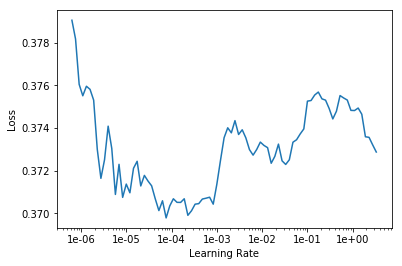

In [ ]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,dice,time
0,0.012173,0.011764,0.784481,36:32
1,0.012103,0.010131,0.784230,36:18
2,0.009535,0.009193,0.796792,36:28
3,0.007452,0.009091,0.801756,36:15
4,0.007473,0.007715,0.805025,36:21
5,0.007313,0.007438,0.805291,34:35


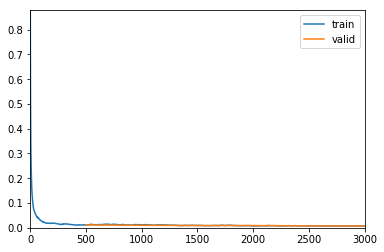

In [ ]:
#fit the decoder part of the model keeping the encode frozen
lr = 1e-3
learn.fit_one_cycle(6, lr, callbacks = [AccumulateStep(learn,n_acc)])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


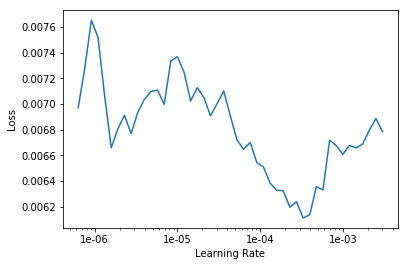

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.save('unethc_256_80d')

epoch,train_loss,valid_loss,dice,time
0,0.008179,0.007950,0.796994,34:29
1,0.007990,0.008233,0.800425,35:02
2,0.008431,0.007620,0.802732,34:35
3,0.006930,0.007943,0.807155,34:25


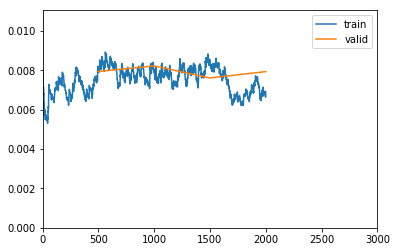

Epoch 1: reducing lr to 9.944154354509119e-05
Epoch 3: reducing lr to 4.6263710266697515e-05


In [ ]:
learn.unfreeze()
learn.fit_one_cycle(6, slice(lr/80, lr/2), callbacks=[AccumulateStep(learn,n_acc)])

In [ ]:
learn.save('unethc_256_81d')

In [ ]:
learn = unet_learner(data, models.resnet34, metrics=[dice], callback_fns=cbfs, self_attention=True).load('unethc_256_80d')
learn.clip_grad(1.0);
set_BN_momentum(learn.model)

In [ ]:
stage_file='models/unethc_256_80d.pth'
ls_gcp(path_models)
# upload_files_to_gcp(stage_file, path_models+'Radiology/Pneumothorax_models/')

gs://medbotai/models/
gs://medbotai/models/Pneumonia_models
gs://medbotai/models/BreastCancer_models/
gs://medbotai/models/Dermatology/
gs://medbotai/models/Lab_models/
gs://medbotai/models/Ophthalmology/
gs://medbotai/models/Pneumonia_models/
gs://medbotai/models/Radiology/
gs://medbotai/models/skin_cancer/


### Cross Validation Training

fold:  0


epoch,train_loss,valid_loss,dice,time
0,0.014230,0.012238,0.773973,32:16
1,0.011908,0.012925,0.782495,31:48
2,0.010844,0.009062,0.768815,31:45
3,0.009876,0.008822,0.800213,31:39
4,0.007968,0.007896,0.803860,31:47


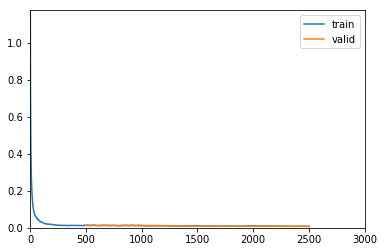

Epoch 1: reducing lr to 0.00019888308709018236


In [ ]:
scores, best_thrs = [],[]

for fold in range(nfolds):
    print('fold: ', fold)
    data = get_fdata(fold)
    learn = unet_learner(data, models.resnet34, metrics=[dice], callback_fns=cbfs)
    learn.clip_grad(1.0);
    set_BN_momentum(learn.model)
    
    #fit the decoder part of the model keeping the encode frozen
    lr = 1e-3
    learn.fit_one_cycle(6, lr, callbacks = [AccumulateStep(learn,n_acc)])
    
    #fit entire model with saving on the best epoch
    learn.unfreeze()
    learn.fit_one_cycle(12, slice(lr/80, lr/2), callbacks=[AccumulateStep(learn,n_acc)])
    learn.save('fold'+str(fold));
    
    #prediction on val and test sets
    preds, ys = pred_with_flip(learn)
    pt, _ = pred_with_flip(learn,DatasetType.Test)
    
    if fold == 0: preds_test = pt
    else: preds_test += pt
        
    #convert predictions to byte type and save
    preds_save = (preds*255.0).byte()
    torch.save(preds_save, 'preds_fold'+str(fold)+'.pt')
    np.save('items_fold'+str(fold), data.valid_ds.items)
        
    #remove noise
    preds[preds.view(preds.shape[0],-1).sum(-1) < noise_th,...] = 0.0

    #optimal threshold 
    #The best way would be collecting all oof predictions followed by a single threshold
    #calculation. However, it requres too much RAM for high image resolution
    dices = []
    thrs = np.arange(0.01, 1, 0.01)
    for th in progress_bar(thrs):
        preds_m = (preds>th).long()
        dices.append(dice_overall(preds_m, ys).mean())
    dices = np.array(dices)    
    scores.append(dices.max())
    best_thrs.append(thrs[dices.argmax()])
     
    if fold != nfolds-1: del preds, ys, preds_save
    gc.collect()
    torch.cuda.empty_cache()
    
preds_test /= nfolds

In [ ]:
lr= 1e-3
learner.fit_one_cycle(5, max_lr=slice(1e-4, lr), wd=1e-2)

In [ ]:
learner.save('stage-1')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


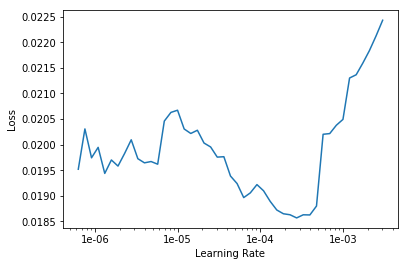

In [ ]:
learner.unfreeze()
learner.to_fp16()
learner.lr_find()
learner.recorder.plot()

In [ ]:
lr= 1e-3
learner.fit_one_cycle(20, max_lr=slice(1e-5,1e-4, lr/2), wd=1e-2)

## Evaluation

In [ ]:
interp = SegmentationInterpretation.from_learner(learn)
top_losses, top_idxs = interp.top_losses(sizes=(256,256))

In [ ]:
learn.data.classes


['void', 'Pneumothorax']

In [ ]:
mean_cm, single_img_cm = interp._generate_confusion()

In [ ]:
df = interp._plot_intersect_cm(mean_cm, "Mean of Ratio of Intersection given True Label")
df

label,score
void,1
Pneumothorax,0


,label,score
0,void,1
1,Pneumothorax,0


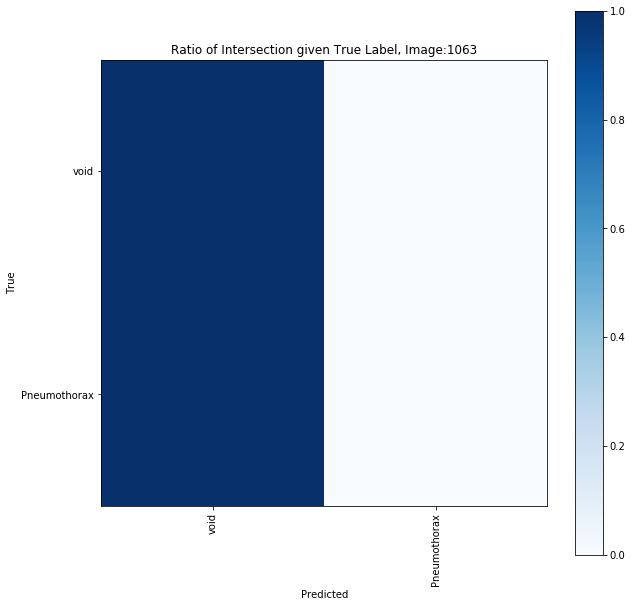

In [ ]:
i = top_idxs[0]
df = interp._plot_intersect_cm(single_img_cm[i], f"Ratio of Intersection given True Label, Image:{i}")
df

In [ ]:
interp.show_xyz(i, sz=15)

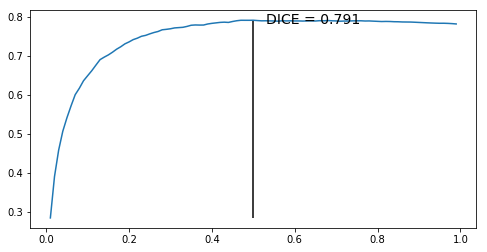

In [ ]:
# Predictions for the validation set
preds, ys = learn.get_preds()
preds = preds[:,1,...]
ys = ys.squeeze()

# Find optimal threshold
dices = []
thrs = np.arange(0.01, 1, 0.01)
for i in progress_bar(thrs):
    preds_m = (preds>i).long()
    dices.append(dice_overall(preds_m, ys).mean())
dices = np.array(dices)


best_dice = dices.max()
best_thr = thrs[dices.argmax()]

plt.figure(figsize=(8,4))
plt.plot(thrs, dices)
plt.vlines(x=best_thr, ymin=dices.min(), ymax=dices.max())
plt.text(best_thr+0.03, best_dice-0.01, f'DICE = {best_dice:.3f}', fontsize=14);
plt.show()

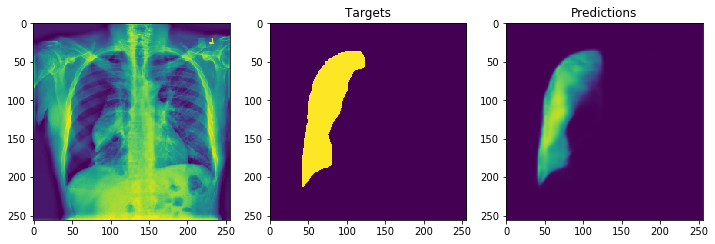

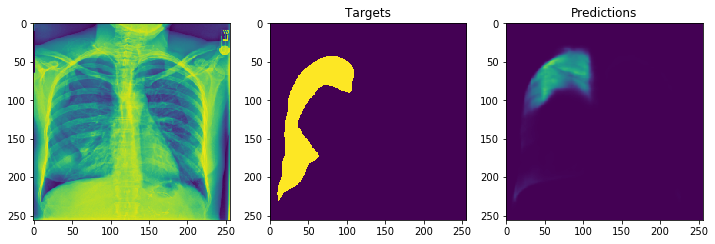

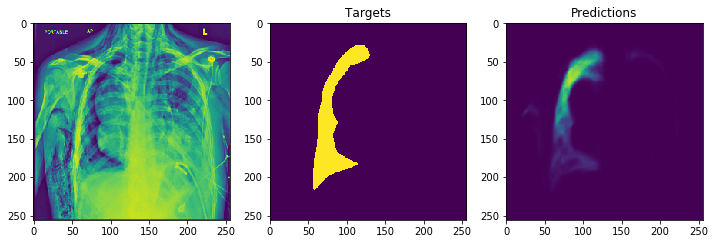

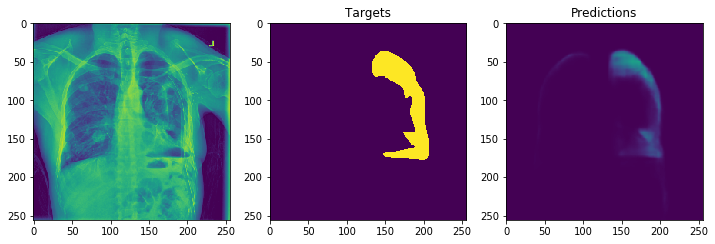

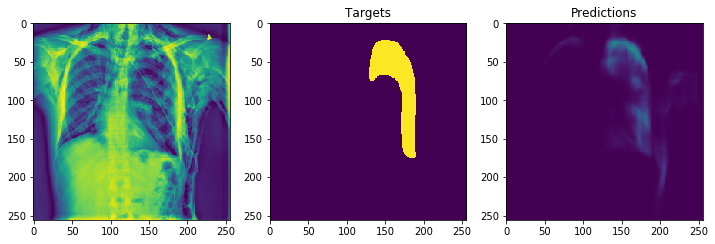

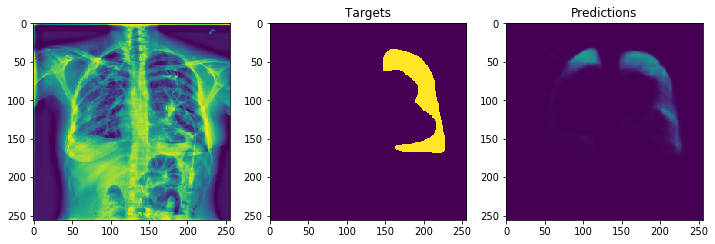

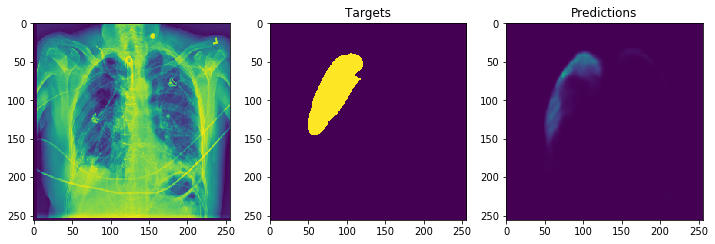

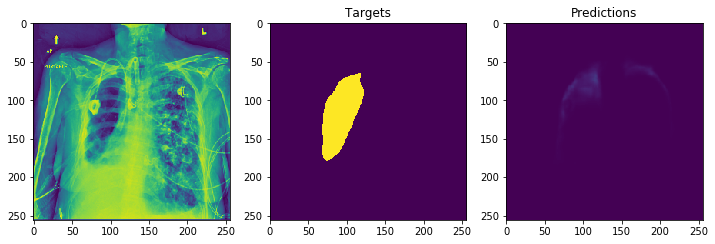

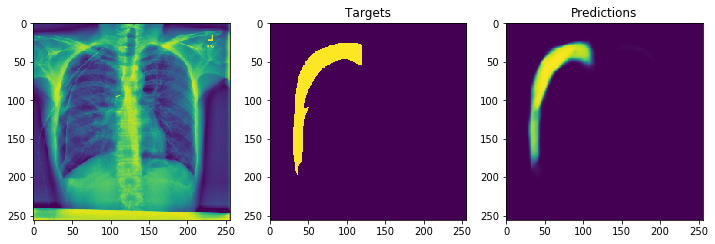

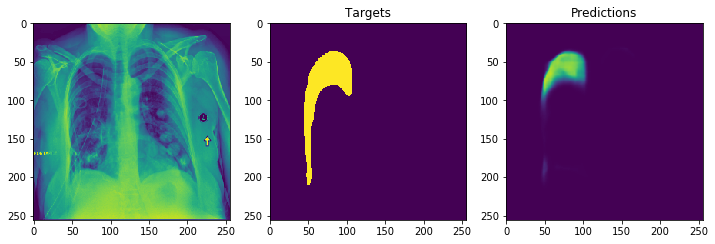

In [ ]:
# Plot some samples
rows = 10
plot_idx = ys.sum((1,2)).sort(descending=True).indices[:rows]
for idx in plot_idx:
    fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(12, 4))
    ax0.imshow(data.valid_ds[idx][0].data.numpy()[0])
    ax1.imshow(ys[idx], vmin=0, vmax=1)
    ax2.imshow(preds[idx], vmin=0, vmax=1)
    ax1.set_title('Targets')
    ax2.set_title('Predictions')